In [1]:
# Importar librerías

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# **Lectura de datos**

In [2]:
#extraer los datos
url = 'https://drive.google.com/uc?id=13vGFJejB7FAarWNcJvzIgnMVzSFs4b7K'

df_obesidad = pd.read_csv(url)

In [5]:
# Realizar una copia de los datos

df_obesidad_copy = df_obesidad

# **Análisis exploratorio**

In [3]:
# visualizar los datos
df_obesidad.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight


In [3]:
# Renombramiento de columnas

df_obesidad.rename(columns={"Gender":"GENERO","Age":"EDAD","Height":"ALTURA","Weight":"PESO","family_history_with_overweight":"HISTORIAL_FAMILIAR","FAVC":"ALIMENTOS_CALORIAS","FCVC":"FRECUENCIA_VERDURAS","NCP":"COMIDAS_PRINCIPALES","CAEC":"ENTRE_COMIDAS","SMOKE":"FUMADOR","CH2O":"AGUA_DIARIA","SCC":"MONITOREA_CALORIAS","FAF":"ACTIVIDAD_FISICA","TUE":"TIEMPO_DISPOSITIVOS","CALC":"FRECUENCIA_ALCOHOL","MTRANS":"MEDIO_TRANSPORTE","NObeyesdad":"NIVEL_OBESIDAD"},inplace=True)


In [4]:
# Eliminación de variable objetivo

df_obesidad = df_obesidad.drop('NIVEL_OBESIDAD', axis=1)

In [6]:
df_obesidad.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation


In [8]:
#dimensión del dataset

df_obesidad.shape

(2111, 16)

In [8]:
df_obesidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENERO               2111 non-null   object 
 1   EDAD                 2111 non-null   float64
 2   ALTURA               2111 non-null   float64
 3   PESO                 2111 non-null   float64
 4   HISTORIAL_FAMILIAR   2111 non-null   object 
 5   ALIMENTOS_CALORIAS   2111 non-null   object 
 6   FRECUENCIA_VERDURAS  2111 non-null   float64
 7   COMIDAS_PRINCIPALES  2111 non-null   float64
 8   ENTRE_COMIDAS        2111 non-null   object 
 9   FUMADOR              2111 non-null   object 
 10  AGUA_DIARIA          2111 non-null   float64
 11  MONITOREA_CALORIAS   2111 non-null   object 
 12  ACTIVIDAD_FISICA     2111 non-null   float64
 13  TIEMPO_DISPOSITIVOS  2111 non-null   float64
 14  FECUENCIA_ALCOHOL    2111 non-null   object 
 15  MEDI0_TRANSPORTE     2111 non-null   o

In [17]:
df_obesidad.describe()

,EDAD,ALTURA,PESO,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


Al analizar los datos numericos de la tabla podemos observar que la variable EDAD se comporta con normalidad, además la variable ALTURA se supone que está en metros y PESO está en kilos. Tambien se puede observar que la varible FRECUENCIA_VERDURAS es el número de veces que una persona incluye verduras en una de sus comidas al día y COMIDAS_PRINCIPALES el el número de comidas principales que consume una persona al día.

De ahí, se puede observar que los datos numéricos no parecen presentar datos atípicos o extremos que puedan llegar a afectar el desarrollo del proyecto, además, no se evidencian datos nulos o faltantes.

## **Datos faltantes** 

In [9]:
df_obesidad.isnull().sum()

GENERO                 0
EDAD                   0
ALTURA                 0
PESO                   0
HISTORIAL_FAMILIAR     0
ALIMENTOS_CALORIAS     0
FRECUENCIA_VERDURAS    0
COMIDAS_PRINCIPALES    0
ENTRE_COMIDAS          0
FUMADOR                0
AGUA_DIARIA            0
MONITOREA_CALORIAS     0
ACTIVIDAD_FISICA       0
TIEMPO_DISPOSITIVOS    0
FRECUENCIA_ALCOHOL     0
MEDIO_TRANSPORTE       0
dtype: int64

In [10]:
df_obesidad.head()

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


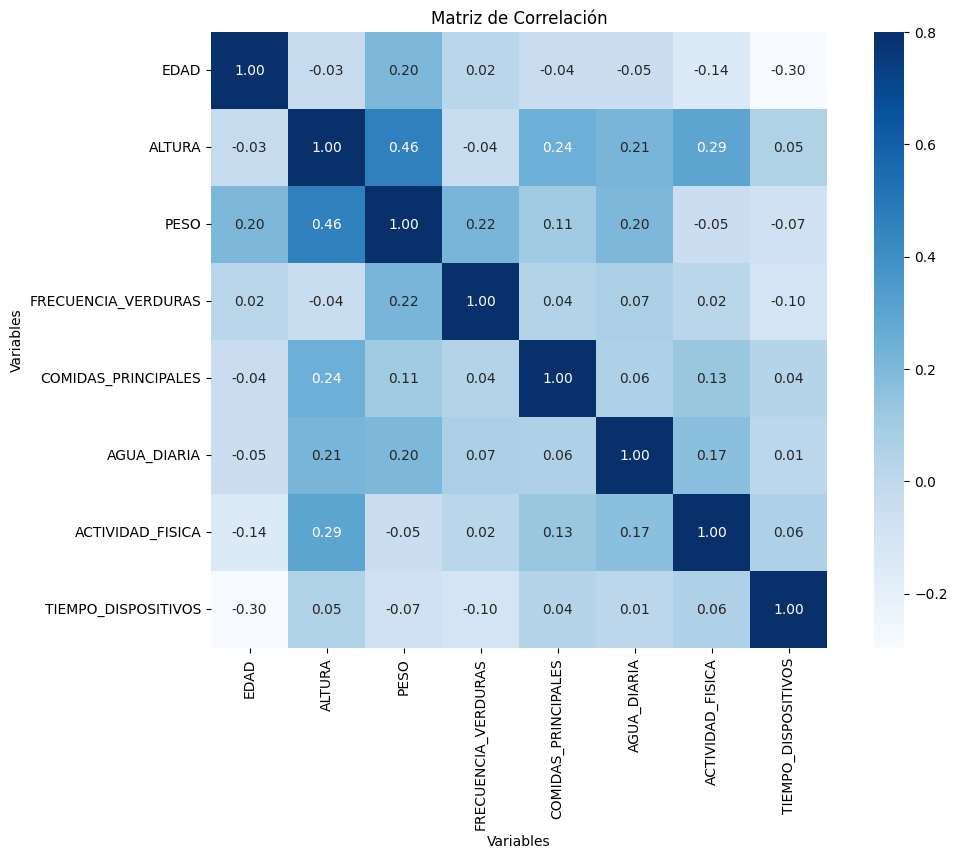

In [8]:
#Matriz de correlación 

# Seleccionar columnas numéricas
columnas_numericas = [col for col in df_obesidad.columns if df_obesidad[col].dtype != 'object']

# Filtrar DataFrame a las variables numéricas
df_numerico = df_obesidad[columnas_numericas]

# Calcular la matriz de correlación
corrmat = df_numerico.corr()

# Configurar tamaño de la figura
f, ax = plt.subplots(figsize=(12, 8))

# Mostrar la matriz de correlación como mapa de calor
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, annot_kws={"fontsize": 10}, fmt=".2f", cmap='Blues')

# Agregar título y etiquetas
plt.title('Matriz de Correlación')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Mostrar la figura
plt.show()


De la matriz de correlación podemos observar que se presenta una relación correlación positiva entre el peso y la altura (relación que es de esperarse), sin embargo no presenta un valor de correlación considerable, por ende se decide mantener las variables que posee el dataset.

### **Exploración de variables**

In [78]:
# Columna 'GENERO'
df_obesidad['GENERO'].describe()
df_obesidad['GENERO'].value_counts()

Male      1068
Female    1043
Name: GENERO, dtype: int64

Al analizar la variable *'GENERO'* podemos ver que cuenta con un número de observaciones similar entre hombres (50.6%) y mujeres (49.4%).


In [79]:
# Columna 'HISTORIAL_FAMILIAR'
df_obesidad['HISTORIAL_FAMILIAR'].describe()
df_obesidad['HISTORIAL_FAMILIAR'].value_counts()

yes    1726
no      385
Name: HISTORIAL_FAMILIAR, dtype: int64

Se puede apreciar que el 81.76% de las personas del estudio posee antecedentes familiares por obesidad.

In [22]:
# Columna 'ALIMENTOS_CALORIAS' ALIMENTOS ALTOS EN CALORIAS
df_obesidad['ALIMENTOS_CALORIAS'].describe()
df_obesidad['ALIMENTOS_CALORIAS'].value_counts()

yes    1866
no      245
Name: ALIMENTOS_CALORIAS, dtype: int64

In [24]:
# Columna 'FECUENCIA_VERDURAS' 
df_obesidad['FRECUENCIA_VERDURAS'].describe()	
df_obesidad['FRECUENCIA_VERDURAS'].value_counts()

3.000000    652
2.000000    600
1.000000     33
2.823179      2
2.214980      2
           ... 
2.927409      1
2.706134      1
2.010684      1
2.300408      1
2.680375      1
Name: FRECUENCIA_VERDURAS, Length: 810, dtype: int64

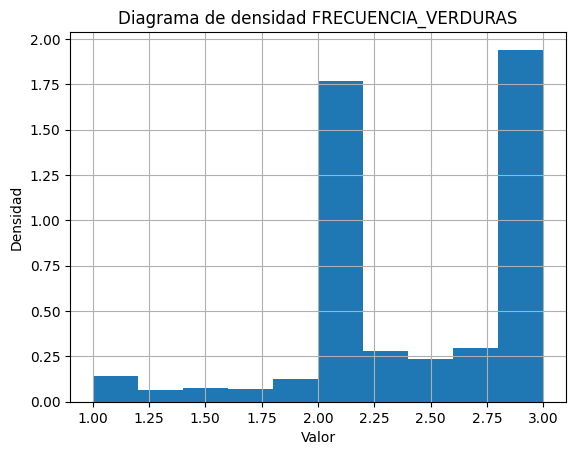

In [9]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['FRECUENCIA_VERDURAS'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad FRECUENCIA_VERDURAS')
plt.grid(True)

# Mostrar el gráfico
plt.show()

En el caso de la variable *'FRECUENCIA_VERDURAS'* se observa que la mayoría de valores se centran en los valores enteros (como 3, 2 y 1). Además, se observa que al parecer el valor de esta variable se encuentra expresado como un promedio dado que existen diversas observaciones con valores decimales. Para facilitar el análisis y garantizar resultados más coherentes se podría optar por aproximar dichos valores decimales al entero más cercano.

In [25]:
#COLUMNA COMIDAS_PRINCIPALES	
df_obesidad['COMIDAS_PRINCIPALES'].describe()
df_obesidad['COMIDAS_PRINCIPALES'].value_counts()

3.000000    1203
1.000000     199
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: COMIDAS_PRINCIPALES, Length: 635, dtype: int64

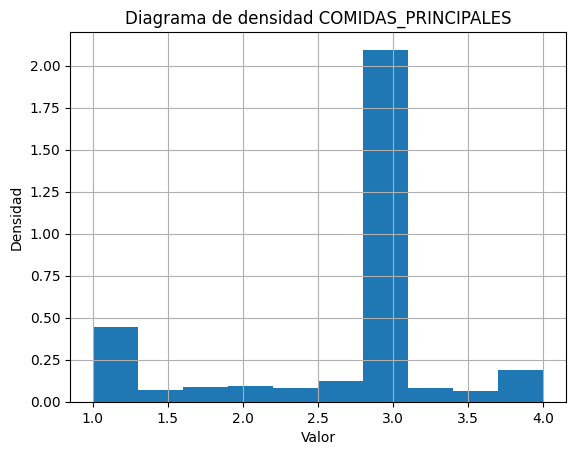

In [10]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['COMIDAS_PRINCIPALES'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad COMIDAS_PRINCIPALES')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Para el caso de *'COMIDAS_PRINCIPALES'* se podría llevar a cabo el mismo procedimiento que para *'FRECUENCIA_VERDURAS'*.

In [26]:
#COLUMA ENTRE_COMIDAS

df_obesidad['ENTRE_COMIDAS'].describe()
df_obesidad['ENTRE_COMIDAS'].value_counts()


Sometimes     1765
Frequently     242
Always          53
no              51
Name: ENTRE_COMIDAS, dtype: int64

En el caso de la variable *'ENTRE_COMIDAS'* se observa que es una variable categórica ordinal que sólo posee 4 clases, por ende, sería conveniente convertirla a numérica de acuerdo al orden de la variable. Por ejemplo, para la clase *'no'* se puede reemplazar por 0, *'Sometimes'* por 1, *'Frequently'* por 2 y finalmente, *'Always'* por 3 de modo que se mantenga el orden y el peso de las categorias.

In [27]:
#COLUMNA FUMADOR 

df_obesidad['FUMADOR'].describe()
df_obesidad['FUMADOR'].value_counts()


no     2067
yes      44
Name: FUMADOR, dtype: int64

De la variable *'FUMADOR'* se puede observar que la mayor parte de la población del estudio no son fumadores, solamente fuman el 2.08% de ellas. Ahora, se observa que esta variable se encuentra clasificada como 'yes' y 'no' por lo que para variables de este estilo se puede reemplazar 'yes' por 1 y 'no' por 0 de modo que sean numéricas. 


In [28]:
#COLUMNA AGUA_DIARIA	
df_obesidad['AGUA_DIARIA'].describe()
df_obesidad['AGUA_DIARIA'].value_counts()

2.000000    448
1.000000    211
3.000000    162
2.825629      3
1.636326      3
           ... 
1.622638      1
2.452986      1
2.035954      1
1.944095      1
2.863513      1
Name: AGUA_DIARIA, Length: 1268, dtype: int64

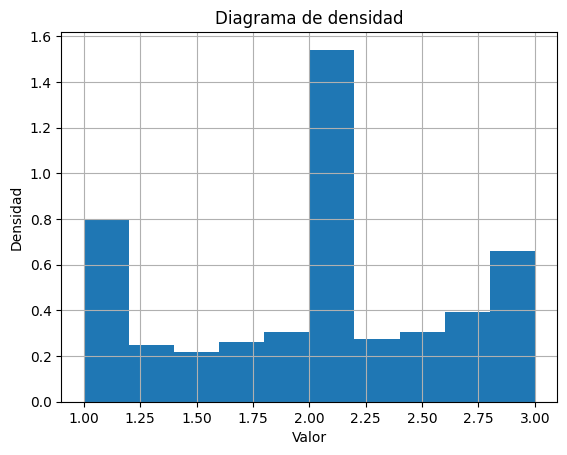

In [21]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['AGUA_DIARIA'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad AGUA_DIARIA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

La variable *'AGUA_DIARIA'* se puede asociar a los vasos de aguas que una persona bebe en un día, y para el tratamiento de esta variable se pueden aproximar los valores decimales al entero más cercano.

In [30]:
# COLUMNA MONITOREA_CALORIAS	
df_obesidad['MONITOREA_CALORIAS'].describe()
df_obesidad['MONITOREA_CALORIAS'].value_counts()

no     2015
yes      96
Name: MONITOREA_CALORIAS, dtype: int64

Se puede apreciar que en la columna *'MONITOREA_CALORIAS'* el 95.45% de las personas no está al tanto de cuantas calorias consume al día por lo que esto puede ser un indicador de que las personas no se preocupan por la cantidad de calorias que consumen en un día. Dado el desbalanceo de esta variable puede ser candidata a ser eliminada del dataset.

In [31]:
#COLUMNA ACTIVIDAD_FISICA	
df_obesidad['ACTIVIDAD_FISICA'].describe()
df_obesidad['ACTIVIDAD_FISICA'].value_counts()

0.000000    411
1.000000    234
2.000000    183
3.000000     75
0.110174      2
           ... 
1.916751      1
0.954459      1
0.340915      1
0.986414      1
1.026452      1
Name: ACTIVIDAD_FISICA, Length: 1190, dtype: int64

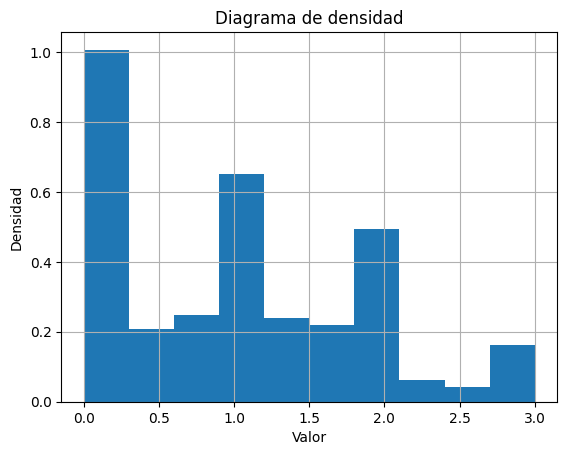

In [20]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['ACTIVIDAD_FISICA'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad ACTIVIDAD_FISICA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Mismo procedimiento de tratamiento que para *'FRECUENCIA_VERDURAS'*.

In [32]:
#COLUMNA TIEMPO_DISPOSITIVOS

df_obesidad['TIEMPO_DISPOSITIVOS'].describe()
df_obesidad['TIEMPO_DISPOSITIVOS'].value_counts()

0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
1.343044      1
1.019452      1
0.673408      1
0.997600      1
0.714137      1
Name: TIEMPO_DISPOSITIVOS, Length: 1129, dtype: int64

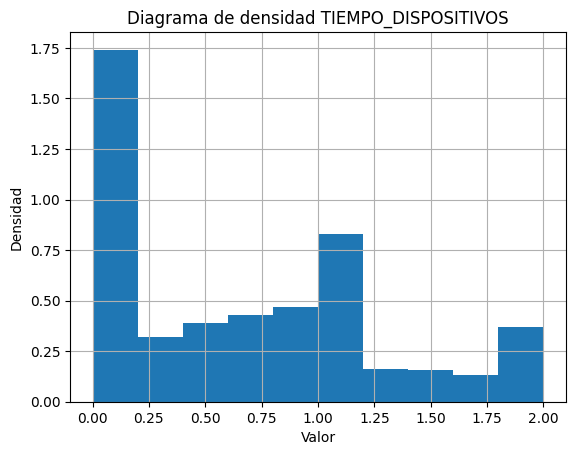

In [11]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['TIEMPO_DISPOSITIVOS'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad TIEMPO_DISPOSITIVOS')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Mismo procedimiento de tratamiento que para *'FRECUENCIA_VERDURAS'*.

In [33]:
#COLUMNA FRECUENCIA_ALCOHOL	

df_obesidad['FRECUENCIA_ALCOHOL'].describe()
df_obesidad['FRECUENCIA_ALCOHOL'].value_counts()


Sometimes     1401
no             639
Frequently      70
Always           1
Name: FECUENCIA_ALCOHOL, dtype: int64

En la columna *'FRECUENCIA_ALCOHOL'* encontramos que el 66.37% de las personas consume alcohol a veces, lo que es un porcentaje alto en las personas del estudio. Esta variable puede ser de importancia, y además, se convertirá a numérica como en el caso de *'ENTRE_COMIDAS'*.

In [34]:
#COLUMNA MEDIO_TRANSPORTE

df_obesidad['MEDIO_TRANSPORTE'].describe()
df_obesidad['MEDIO_TRANSPORTE'].value_counts()

Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MEDI0_TRANSPORTE, dtype: int64

Muy pocas personas utilizan medios de transporte en donde tengan que realizar un esfuerzo físico para llegar a sus destinos, ya que sólo el 2.98% de las personas caminan. Por otro lado, para el tratamiento de esta variable, al no ser una variable categórica ordinal, pues no se puede emplear el mismo procedimiento que para algunas de las variables anteriores, por ende, esta variable simplemente se espera llevar a formato dummy. 

## **Datos duplicados**

In [7]:
# Identificar filas duplicadas
filas_duplicadas = df_obesidad.duplicated()

# Contar el número de filas duplicadas
cantidad_duplicados = filas_duplicadas.sum()
cantidad_duplicados

# Mostrar las filas duplicadas
df_obesidad[filas_duplicadas]


,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
98,Female,21.0,1.52,42.0,no,no,3.0,1.0,Frequently,no,1.0,no,0.0,0.0,Sometimes,Public_Transportation
106,Female,25.0,1.57,55.0,no,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation
174,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
179,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
184,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation
209,Female,22.0,1.69,65.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation
309,Female,16.0,1.66,58.0,no,no,2.0,1.0,Sometimes,no,1.0,no,0.0,1.0,no,Walking
460,Female,18.0,1.62,55.0,yes,yes,2.0,3.0,Frequently,no,1.0,no,1.0,1.0,no,Public_Transportation
467,Male,22.0,1.74,75.0,yes,yes,3.0,3.0,Frequently,no,1.0,no,1.0,0.0,no,Automobile
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation


In [8]:
print("Número de filas duplicadas:", cantidad_duplicados)

Número de filas duplicadas: 24


Se observa que el dataset posee 24 observaciones duplicadas, las cuales se proceden a eliminar.

In [9]:
#Eliminar filas duplicadas

df_obesidad = df_obesidad.drop_duplicates()

In [101]:
df_obesidad.shape

(2087, 15)

# **Análisis univariado**

In [34]:
 variables = ['EDAD', 'ALTURA', 'PESO']
variables2 = ['FRECUENCIA_VERDURAS', 'COMIDAS_PRINCIPALES', 'AGUA_DIARIA']
variables3 = ['ACTIVIDAD_FISICA', 'TIEMPO_DISPOSITIVOS','PESO']


In [35]:
def graficar_boxplots_3(df, variables):
  # Seleccionar las variables
  df_subset = df[variables]

  # Graficar boxplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i, variable in enumerate(variables):
    sns.boxplot(data=df_subset[variable], ax=axes[i])
    axes[i].set_title(variable)

  # Ajustar la figura
  plt.tight_layout()
  plt.show()

def graficar_boxplots_4(df, variables):
  # Seleccionar las variables
  df_subset = df[variables]

  # Graficar boxplots
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  for i, variable in enumerate(variables):
    sns.boxplot(data=df_subset[variable], ax=axes[i])
    axes[i].set_title(variable)

  # Ajustar la figura
  plt.tight_layout()
  plt.show()

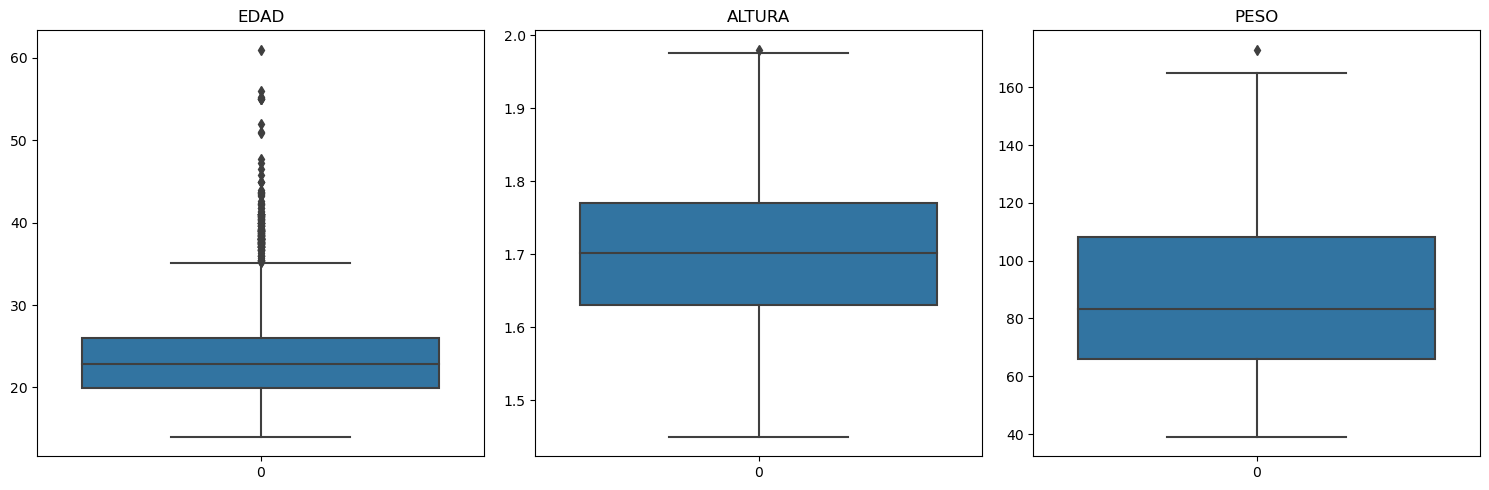

In [26]:
# DATOS PERSONALES
graficar_boxplots_4(df_obesidad, variables)

#############################################################################################################################################################################

Edad: La distribución de la edad parece ser asimétrica, con una mayor concentración de datos hacia la derecha (edades mayores). La mediana de la edad se encuentra alrededor de los 30 años.(tenemos mucho datos atipicos que estan afuera del boxplot). La mediana de de la edad está por debajo de la mediana del peso,lo que indica que las personas menores tienden a tener menor peso

Altura: La distribución de la altura parece ser normal, con una simetría aproximada entre los valores a ambos lados de la mediana. La mediana de la altura se encuentra alrededor de los 165 cm. (tenemos un dato atipico que se aproxima a los 2.0 metros). La mediana de la altura está por encima de la mediana del peso, lo que indica que las personas mal altas tienden a tener un peso mayor

Peso: La distribución del peso también parece ser asimétrica, con una mayor concentración de datos hacia la derecha (pesos mayores). La mediana del peso se encuentra alrededor de los 70 kg. (tenemos un dato atipico por encima de los 160 kg)

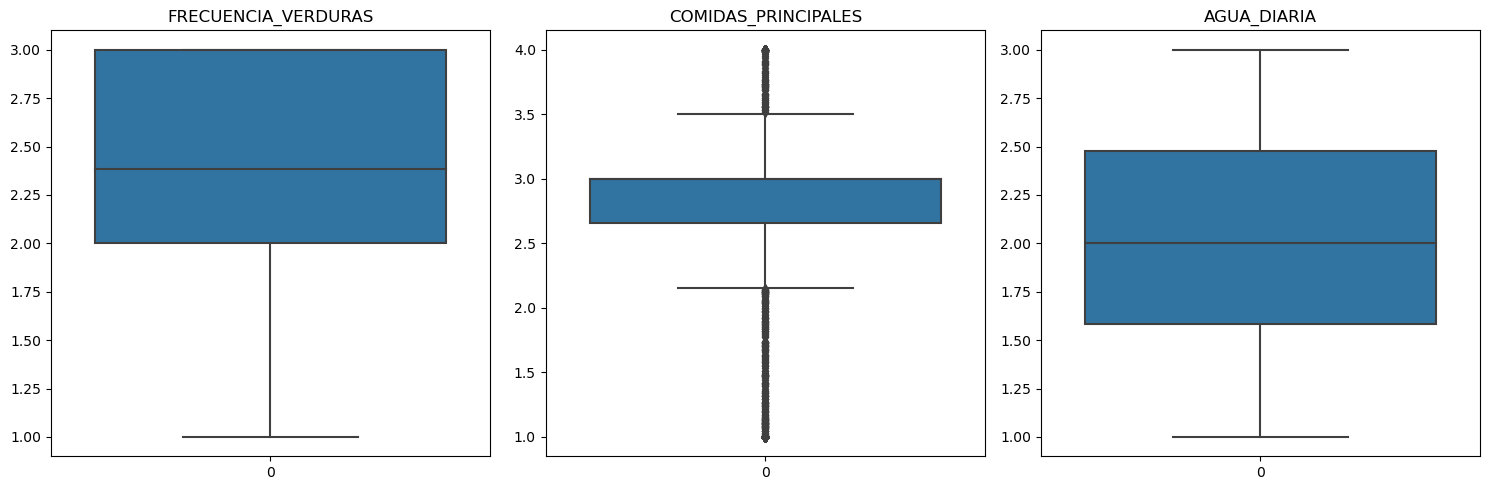

In [47]:
#ALIMENTICIO 
graficar_boxplots_4(df_obesidad, variables2)

En este boxplot llama la atención la variabilidad en la frecuencia con la que las personas comen verduras al día, lo que nos da un boxplot que muestra una variabilidad significativa en los datos.
El grafico de comidas principales presenta muchos valores atipicos por lo que es de vital importancia hacer tratamiento de estos datos 

Por otro lado, el boxplot del consumo de agua diario muestra un comportamiento normal

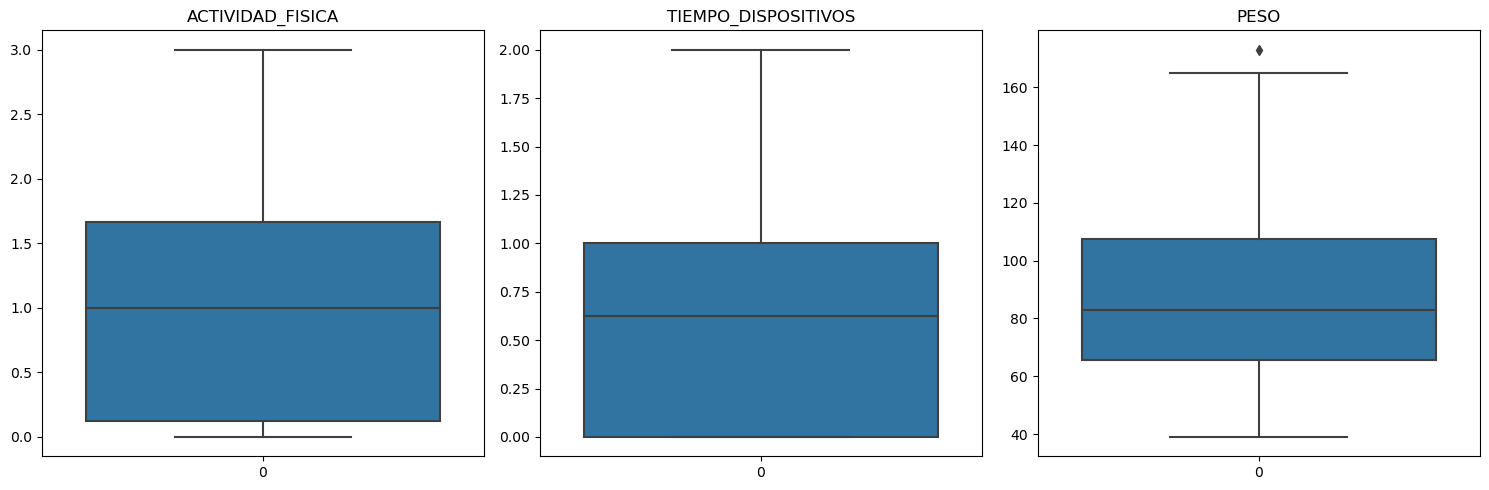

In [51]:
#HABITOS 
graficar_boxplots_4(df_obesidad, variables3)

Los graficos de boxplot de actividad fisica y tiempo de dispositivos presentan una variabilidad significativa por lo que sus boxplot son muy grandes y eso representa variabilidad en la muestra.

## TRATAMIENTO DE DATOS



Convertir las columnas binarias en 1 y 0 utilizando la función replace

In [10]:
df_obesidad["GENERO"] = df_obesidad["GENERO"].replace(['Female', 'Male'], [1, 0]) #Female es 1 y Male es 0
df_obesidad["HISTORIAL_FAMILIAR"] = df_obesidad["HISTORIAL_FAMILIAR"].replace(['yes','no'],[1,0]) # yes es 1 y no es 0
df_obesidad["ALIMENTOS_CALORIAS"] = df_obesidad["ALIMENTOS_CALORIAS"].replace(['yes','no'],[1,0]) # yes es 1 y no es 0
df_obesidad["FUMADOR"] = df_obesidad["FUMADOR"].replace(['yes','no'],[1,0]) # yes es 1 y no es 0
df_obesidad["MONITOREA_CALORIAS"] = df_obesidad["MONITOREA_CALORIAS"].replace(['yes','no'],[1,0]) # yes es 1 y no es 0

C:\Users\srest\AppData\Local\Temp\ipykernel_27848\166113598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad["GENERO"] = df_obesidad["GENERO"].replace(['Female', 'Male'], [1, 0]) #Female es 1 y Male es 0
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\166113598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad["HISTORIAL_FAMILIAR"] = df_obesidad["HISTORIAL_FAMILIAR"].replace(['yes','no'],[1,0]) # yes es 1 y no es 0
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\166113598.py

Ahora, para las variables que poseen valores decimales se aproximan al número entero más cercano.

In [11]:
df_obesidad['FRECUENCIA_VERDURAS'] = df_obesidad['FRECUENCIA_VERDURAS'].round(0)
df_obesidad['COMIDAS_PRINCIPALES'] = df_obesidad['COMIDAS_PRINCIPALES'].round(0)
df_obesidad['AGUA_DIARIA'] = df_obesidad['AGUA_DIARIA'].round(0)
df_obesidad['ACTIVIDAD_FISICA'] = df_obesidad['ACTIVIDAD_FISICA'].round(0)
df_obesidad['TIEMPO_DISPOSITIVOS'] = df_obesidad['TIEMPO_DISPOSITIVOS'].round(0)

C:\Users\srest\AppData\Local\Temp\ipykernel_27848\2885266116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad['FRECUENCIA_VERDURAS'] = df_obesidad['FRECUENCIA_VERDURAS'].round(0)
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\2885266116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad['COMIDAS_PRINCIPALES'] = df_obesidad['COMIDAS_PRINCIPALES'].round(0)
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\2885266116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

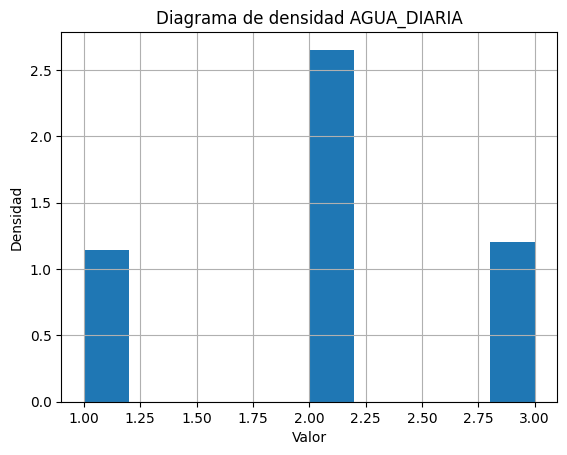

In [10]:
# Crear el diagrama de densidad
plt.hist(df_obesidad['AGUA_DIARIA'], density=True)  # Ajusta el parámetro 'bins' para controlar la granularidad del histograma

# Personalizar el gráfico (opcional)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Diagrama de densidad AGUA_DIARIA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

Convertir las variables que se acaban de tratar de tipo float a int.

In [12]:
variables_numericas = ['FRECUENCIA_VERDURAS', 'COMIDAS_PRINCIPALES', 'AGUA_DIARIA', 'ACTIVIDAD_FISICA', 'TIEMPO_DISPOSITIVOS']

for variable in variables_numericas:
  df_obesidad[variable] = df_obesidad[variable].astype('int64') 

C:\Users\srest\AppData\Local\Temp\ipykernel_27848\1606085350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad[variable] = df_obesidad[variable].astype('int64')
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\1606085350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad[variable] = df_obesidad[variable].astype('int64')
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\1606085350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Ahora, para tratar las variables tipo object que son categóricas ordinales, se reemplazan por números.

In [13]:
df_obesidad['ENTRE_COMIDAS'] = df_obesidad['ENTRE_COMIDAS'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])
df_obesidad['FRECUENCIA_ALCOHOL'] = df_obesidad['FRECUENCIA_ALCOHOL'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])

C:\Users\srest\AppData\Local\Temp\ipykernel_27848\1284619313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad['ENTRE_COMIDAS'] = df_obesidad['ENTRE_COMIDAS'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])
C:\Users\srest\AppData\Local\Temp\ipykernel_27848\1284619313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad['FRECUENCIA_ALCOHOL'] = df_obesidad['FRECUENCIA_ALCOHOL'].replace(['no','Sometimes','Frequently','Always'],[0,1,2,3])


In [14]:
df_obesidad.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,FUMADOR,AGUA_DIARIA,MONITOREA_CALORIAS,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE
0,1,21.0,1.62,64.0,1,0,2,3,1,0,2,0,0,1,0,Public_Transportation
1,1,21.0,1.52,56.0,1,0,3,3,1,1,3,1,3,0,1,Public_Transportation
2,0,23.0,1.80,77.0,1,0,2,3,1,0,2,0,2,1,2,Public_Transportation


**Alternativa 1**

Para la variable '*MEDIO_TRANSPORTE*' se decide dummizar dado que posee con 5 clases.

In [15]:
df_oficial = pd.get_dummies(df_obesidad['MEDIO_TRANSPORTE'], prefix='MEDIO_TRANSPORTE')

In [16]:
df_oficial.head(3)

,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Bike,MEDIO_TRANSPORTE_Motorbike,MEDIO_TRANSPORTE_Public_Transportation,MEDIO_TRANSPORTE_Walking
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False


In [16]:
del df_obesidad['MEDIO_TRANSPORTE']

In [17]:
df_oficial = pd.concat([df_obesidad, df_oficial], axis=1)

Y finalmente se cambian de tipo bool a int (0 y 1):

In [18]:
df_oficial["MEDIO_TRANSPORTE_Bike"] = df_oficial["MEDIO_TRANSPORTE_Bike"].replace([True,False],[1,0])
df_oficial["MEDIO_TRANSPORTE_Motorbike"] = df_oficial["MEDIO_TRANSPORTE_Motorbike"].replace([True,False],[1,0])
df_oficial["MEDIO_TRANSPORTE_Public_Transportation"] = df_oficial['MEDIO_TRANSPORTE_Public_Transportation'].replace([True,False],[1,0])
df_oficial["MEDIO_TRANSPORTE_Automobile"] = df_oficial["MEDIO_TRANSPORTE_Automobile"].replace([True,False],[1,0])
df_oficial["MEDIO_TRANSPORTE_Walking"] = df_oficial["MEDIO_TRANSPORTE_Walking"].replace([True,False],[1,0])

**Alternativa 2**

Reemplazar la variable *'MEDIO_TRANSPORTE'* por la frecuencia:

In [21]:
# Calcular la frecuencia de cada categoría MEDIO_TRANSPORTE
frecuencia = df_obesidad['MEDIO_TRANSPORTE'].value_counts(normalize=True)
# Aplicar la codificación de frecuencia
df_obesidad['MEDIO_TRANSPORTE'] = df_obesidad['MEDIO_TRANSPORTE'].map(frecuencia)

C:\Users\srest\AppData\Local\Temp\ipykernel_29256\3744181048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesidad['MEDIO_TRANSPORTE'] = df_obesidad['MEDIO_TRANSPORTE'].map(frecuencia)


In [24]:
df_oficial = df_obesidad

In [25]:
df_oficial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GENERO               2087 non-null   int64  
 1   EDAD                 2087 non-null   float64
 2   ALTURA               2087 non-null   float64
 3   PESO                 2087 non-null   float64
 4   HISTORIAL_FAMILIAR   2087 non-null   int64  
 5   ALIMENTOS_CALORIAS   2087 non-null   int64  
 6   FRECUENCIA_VERDURAS  2087 non-null   int64  
 7   COMIDAS_PRINCIPALES  2087 non-null   int64  
 8   ENTRE_COMIDAS        2087 non-null   int64  
 9   FUMADOR              2087 non-null   int64  
 10  AGUA_DIARIA          2087 non-null   int64  
 11  MONITOREA_CALORIAS   2087 non-null   int64  
 12  ACTIVIDAD_FISICA     2087 non-null   int64  
 13  TIEMPO_DISPOSITIVOS  2087 non-null   int64  
 14  FRECUENCIA_ALCOHOL   2087 non-null   int64  
 15  MEDIO_TRANSPORTE     2087 non-null   float6

## **Gráficos después de tratamiento**

In [17]:
def visualizar_histogramas_20(df, columnas, nfilas=3, ncolumnas=3):
    
  # Crear una figura de nfilas x ncolumnas subplots
  fig, axes = plt.subplots(nfilas, ncolumnas, figsize=(12, 12))

  # Recorrer las columnas y crear un histograma para cada una
  for i, columna in enumerate(columnas):
    row = i // ncolumnas
    col = i % ncolumnas
    axes[row, col].hist(df[columna])

  # Ajustar el título y etiquetas del subplot
    axes[row, col].set_title(columna, fontsize=8)  # Reducir el tamaño del título
    axes[row, col].set_xlabel(columna, fontsize=8)  # Reducir el tamaño de la etiqueta del eje X
    axes[row, col].set_ylabel('Frecuencia', fontsize=8)  # Reducir el tamaño de la etiqueta del eje Y

    # Ajustar el diseño de la figura
    fig.suptitle('Histogramas', fontsize=12)  # Ajustar el tamaño del título principal
    fig.tight_layout()

  # Mostrar la figura
  plt.show()

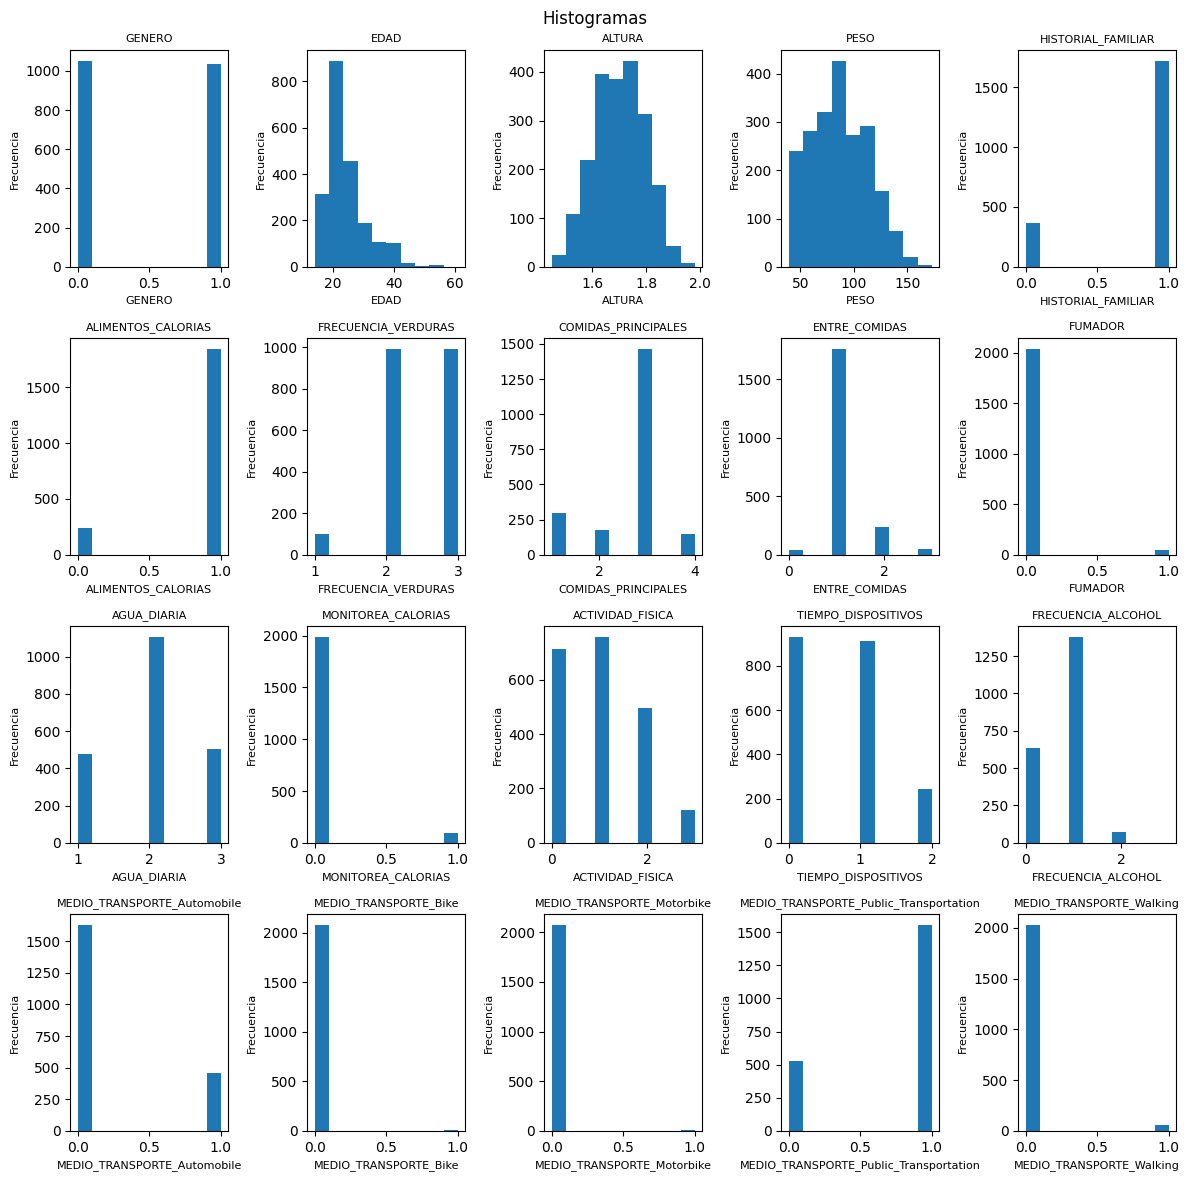

In [19]:
visualizar_histogramas_20(df_oficial, columnas=df_oficial.columns, nfilas=4, ncolumnas=5)

De la gráfica se puede evidenciar que existen variables desbalanceadas que se podrían eliminar dada la poca explicabilidad que ofrecen, por ejemplo: '*FUMADOR*', '*MONITOREA_CALORIAS*', '*MEDIO_TRANSPORTE_Bike*', '*MEDIO_TRANSPORTE_Motorbike*' y '*MEDIO_TRANSPORTE_Walking*'.

### **Eliminación de columnas**

In [19]:
df_oficial = df_oficial.drop(['MEDIO_TRANSPORTE_Bike', 'MEDIO_TRANSPORTE_Motorbike', 'MEDIO_TRANSPORTE_Walking', 'FUMADOR', 'MONITOREA_CALORIAS'], axis=1)

In [20]:
df_oficial.head(5)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Public_Transportation
0,1,21.0,1.62,64.0,1,0,2,3,1,2,0,1,0,0,1
1,1,21.0,1.52,56.0,1,0,3,3,1,3,3,0,1,0,1
2,0,23.0,1.80,77.0,1,0,2,3,1,2,2,1,2,0,1
3,0,27.0,1.80,87.0,0,0,3,3,1,2,2,0,2,0,0
4,0,22.0,1.78,89.8,0,0,2,1,1,2,0,0,1,0,1


# **Modelos de clustering - Aprendizaje no supervisado**

# **1. K-means**

En primer lugar se realiza el escalado de los datos para proceder al montaje de los modelos.

In [21]:
scaler = StandardScaler()
df_oficial_std=pd.DataFrame(scaler.fit_transform(df_oficial),columns=df_oficial.columns)
df_oficial_std.head(5)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Public_Transportation
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,-1.123103,0.489960,-1.411836,-0.528756,0.582699
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,0.981186,0.372182,-0.318128,1.442734,2.215808,-0.994142,0.522834,-0.528756,0.582699
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,1.102838,0.489960,2.457503,-0.528756,0.582699
3,-0.991887,0.415705,1.044677,0.005395,-2.172052,-2.754719,0.981186,0.372182,-0.318128,-0.016784,1.102838,-0.994142,2.457503,-0.528756,-1.716153
4,-0.991887,-0.369560,0.830001,0.112328,-2.172052,-2.754719,-0.728109,-2.137489,-0.318128,-0.016784,-1.123103,-0.994142,0.522834,-0.528756,0.582699


### **1.1. K-means con datos base escalados**

Número óptimo de clusters para los datos base escalados:

In [22]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(df_oficial_std)
    inertia_list.append(kmeans.inertia_)

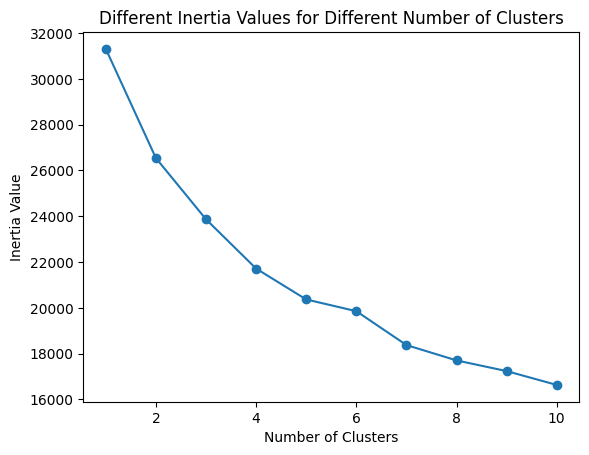

In [23]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [24]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

De acuerdo con la prueba del codo y el KneeLocator se utilizarán 4 clusters.

In [25]:
# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4)
model_kmeans.fit(df_oficial_std)

KMeans(n_clusters=4)

In [26]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(df_oficial_std, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(df_oficial_std, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  22465.484195481935
Silhouette Score:  0.17330649850393903
Calinski harabasz score:  273.2022880696056


Una vez ejecutado el modelo de K-means para el conjunto de datos sin reducción de la dimensionalidad se obtiene un Silhouette Score cercano al 0.173, el cual es cercano a 0 por ende se puede entender que el modelo no agrupa de forma tan precisa o que la separación entre clusters no es considerable. Además, el Calinski Harabasz Score arroja un valor de 273.2 el cual se debe comparar con otros modelos de K-means para poder concluir.

In [27]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(df_oficial_std)
Cluster_1

array([2, 2, 1, ..., 0, 0, 0])

In [28]:
# Vamos a adjuntar 'Cluster_1' como una nueva variable:
df_final_1 = df_oficial_std.copy()
df_final_1['Cluster_1']= Cluster_1

df_final_1.head()

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Public_Transportation,Cluster_1
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,-1.123103,0.489960,-1.411836,-0.528756,0.582699,2
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,0.981186,0.372182,-0.318128,1.442734,2.215808,-0.994142,0.522834,-0.528756,0.582699,2
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,1.102838,0.489960,2.457503,-0.528756,0.582699,1
3,-0.991887,0.415705,1.044677,0.005395,-2.172052,-2.754719,0.981186,0.372182,-0.318128,-0.016784,1.102838,-0.994142,2.457503,-0.528756,-1.716153,2
4,-0.991887,-0.369560,0.830001,0.112328,-2.172052,-2.754719,-0.728109,-2.137489,-0.318128,-0.016784,-1.123103,-0.994142,0.522834,-0.528756,0.582699,2


In [29]:
df_final_1.Cluster_1.value_counts()

Cluster_1
1    637
0    541
2    465
3    444
Name: count, dtype: int64

Una vez se predicen los clusters, se observa que el cluster 1 es el que mayor número de observaciones posee. Además, los clusters 2 y 3 son los que menos observaciones agrupa, sin embargo, se mantiene una cantidad de observaciones por cluster que no se distancia notablemente sobre otro.

### **1.2. K-means con reducción de dimensionalidad PCA**

Inicialmente se realiza una reducción de la dimensionalidad de modo que se explique el 55% de la varianza. Se decide elegir este porcentaje dado que al realizar varias pruebas se observa que al aumentar la varianza hasta el 85% se obtiene como resultado alrededor de 10 componentes, los cuales dificultaban el análisis y los últimos componentes no lleganba a explicar un porcentaje significativo de la varianza.

In [99]:
#Cree un dataset reducido con el 55% de la varianza explicada
pca = PCA(n_components=0.55).fit(df_oficial_std)

#Veamos cuántas componentes ha conservado PCA:
pca.n_components_

5

In [80]:
vp = pd.DataFrame(pca.components_)
vp.columns = [i for i in df_oficial_std.columns]
vp

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Public_Transportation
0,-0.288737,0.400864,0.319020,0.302817,0.283345,0.165121,-0.049145,0.094389,-0.171153,0.104445,0.045931,-0.138705,0.082368,0.443831,-0.422223
1,0.213068,0.301350,-0.394669,-0.388091,-0.238323,-0.195935,-0.041199,-0.126545,0.155492,-0.232457,-0.121886,-0.169128,-0.134089,0.386501,-0.394303
2,-0.415679,-0.209141,0.310060,-0.303085,-0.267891,-0.221920,-0.284373,0.228169,0.256962,-0.020227,0.455111,0.151184,-0.142301,0.073859,-0.139299
3,0.215366,0.035760,0.035180,0.079473,-0.131077,-0.310957,0.555695,0.367437,0.221836,0.328477,0.240015,-0.314661,0.267580,0.006922,-0.041573
4,-0.006949,-0.008810,0.077518,-0.002259,-0.254072,0.278769,-0.170909,0.314906,0.270752,-0.292129,-0.338814,0.092022,0.663651,0.028710,-0.007312


In [97]:
vp_transpuesto = vp.transpose()

# Mostrar el DataFrame transpuesto para determinar la primera variable latente
vp_transpuesto_ordenado = vp_transpuesto.sort_values(by=0, ascending=False)

vp_transpuesto_ordenado

,0,1,2,3,4
MEDIO_TRANSPORTE_Automobile,0.443831,0.386501,0.073859,0.006922,0.028710
EDAD,0.400864,0.301350,-0.209141,0.035760,-0.008810
ALTURA,0.319020,-0.394669,0.310060,0.035180,0.077518
PESO,0.302817,-0.388091,-0.303085,0.079473,-0.002259
HISTORIAL_FAMILIAR,0.283345,-0.238323,-0.267891,-0.131077,-0.254072
ALIMENTOS_CALORIAS,0.165121,-0.195935,-0.221920,-0.310957,0.278769
AGUA_DIARIA,0.104445,-0.232457,-0.020227,0.328477,-0.292129
COMIDAS_PRINCIPALES,0.094389,-0.126545,0.228169,0.367437,0.314906
FRECUENCIA_ALCOHOL,0.082368,-0.134089,-0.142301,0.267580,0.663651
ACTIVIDAD_FISICA,0.045931,-0.121886,0.455111,0.240015,-0.338814


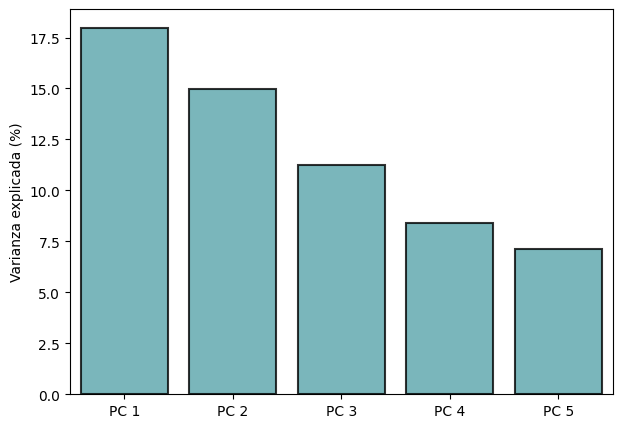

In [84]:
# --- Varianza explicada ---
PCA_variance = pd.DataFrame({'Varianza explicada (%)':
                             pca.explained_variance_ratio_*100})

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

bar = sns.barplot(x = ['PC ' + str(i) for i in range(1, 6)],
                  y = PCA_variance['Varianza explicada (%)'],
                  linewidth = 1.5, edgecolor = 'k', color = '#4bafb8',
                  alpha = 0.8)

plt.show()

In [85]:
PCA_variance

,Varianza explicada (%)
0,17.985409
1,14.958474
2,11.238640
3,8.423683
4,7.146620


In [86]:
PCA_variance.sum()

Varianza explicada (%)    59.752826
dtype: float64

Una vez se realiza la reducción de la dimensionalidad a través de PCA se obtiene como resultado un total de **5 componentes**, los cuales tienen la capacidad de explicar casi el 60% de la varianza, donde uno de ellos explica casi el 18% de ella.

In [88]:
X1_pca = pca.fit_transform(df_oficial_std)
X1_pca

array([[-1.96699892,  0.92171624,  0.02267694, -0.27938307, -1.32447544],
       [-1.81494579,  0.6388417 ,  0.2867613 ,  2.87389605, -2.1093869 ],
       [-0.07592934, -1.15513612,  1.69939654,  0.97814626,  0.64901807],
       ...,
       [ 0.02887372, -1.67547933, -1.34078051,  0.75578767,  0.261259  ],
       [ 0.24937825, -1.86865211, -1.46915682,  1.23967057, -0.17823529],
       [ 0.20483762, -1.90091679, -1.4497575 ,  1.23590537, -0.1777923 ]])

In [89]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X1_pca)
    inertia_list.append(kmeans.inertia_)

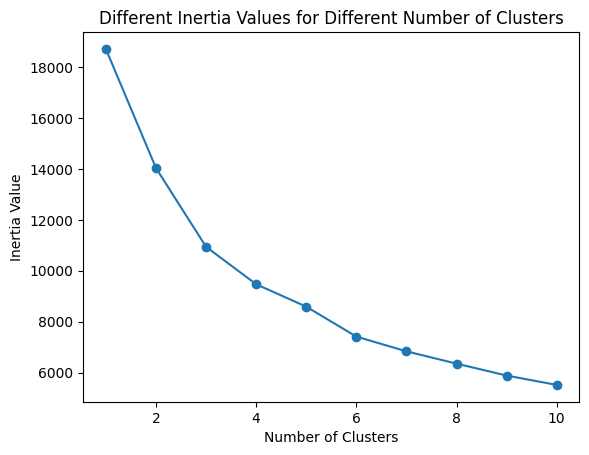

In [90]:
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [91]:
# Seleccion automatica del numero k
kl = KneeLocator(range(1, 11),
                 inertia_list, curve="convex",
                 direction="decreasing")
kl.elbow

4

Una vez se realiza la prueba del codo para los datos reducidos se obtiene que el número óptimo de clusters con el modelo K-means es de 4 clusters.

In [92]:
# --- Modelo K-means ---
model_kmeans_pca_1 = KMeans(n_clusters = 4)
model_kmeans_pca_1.fit(X1_pca)

KMeans(n_clusters=4)

In [93]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans_pca_1.inertia_)
print('Silhouette Score: ', silhouette_score(X1_pca, model_kmeans_pca_1.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X1_pca, model_kmeans_pca_1.labels_))

 ### K-MEANS ###
Inertia:  9481.91341500069
Silhouette Score:  0.2500990304878366
Calinski harabasz score:  675.4257547767271


Ahora, una vez se ejecuta el modelo K-means con el conjunto de datos reducido se obtiene que el Silhoutte score es de 0.25, métrica que es superior al resultado obtenido en el K-means realizado al conjunto de datos sin reducción de dimensionalidad. Así mismo, el valor de Calinski Harabasz arroja como resultado 675.42, el cual también es superior a la métrica obtenida en el K-means anterior. Por ende, se concluye que por ahora la clusterización realizada por K-means al realizar reducción de dimensionalidad con PCA es la más adecuada.

In [94]:
# Predicción de los clusters
Cluster_2 = model_kmeans_pca_1.fit_predict(X1_pca)

df_final_1['Cluster_2']= Cluster_2

df_final_1.head(3)

,GENERO,EDAD,ALTURA,PESO,HISTORIAL_FAMILIAR,ALIMENTOS_CALORIAS,FRECUENCIA_VERDURAS,COMIDAS_PRINCIPALES,ENTRE_COMIDAS,AGUA_DIARIA,ACTIVIDAD_FISICA,TIEMPO_DISPOSITIVOS,FRECUENCIA_ALCOHOL,MEDIO_TRANSPORTE_Automobile,MEDIO_TRANSPORTE_Public_Transportation,Cluster_1,Cluster_2
0,1.008179,-0.526613,-0.887408,-0.872985,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,-1.123103,0.489960,-1.411836,-0.528756,0.582699,2,3
1,1.008179,-0.526613,-1.960788,-1.178508,0.460394,-2.754719,0.981186,0.372182,-0.318128,1.442734,2.215808,-0.994142,0.522834,-0.528756,0.582699,2,3
2,-0.991887,-0.212507,1.044677,-0.376509,0.460394,-2.754719,-0.728109,0.372182,-0.318128,-0.016784,1.102838,0.489960,2.457503,-0.528756,0.582699,1,1


## **2. DBScan**

### **2.1. DBScan con datos base escalados**

### **2.2. DBScan con reducción de dimensionalidad PCA**

# **Interpretación de clusters - K-means con PCA**

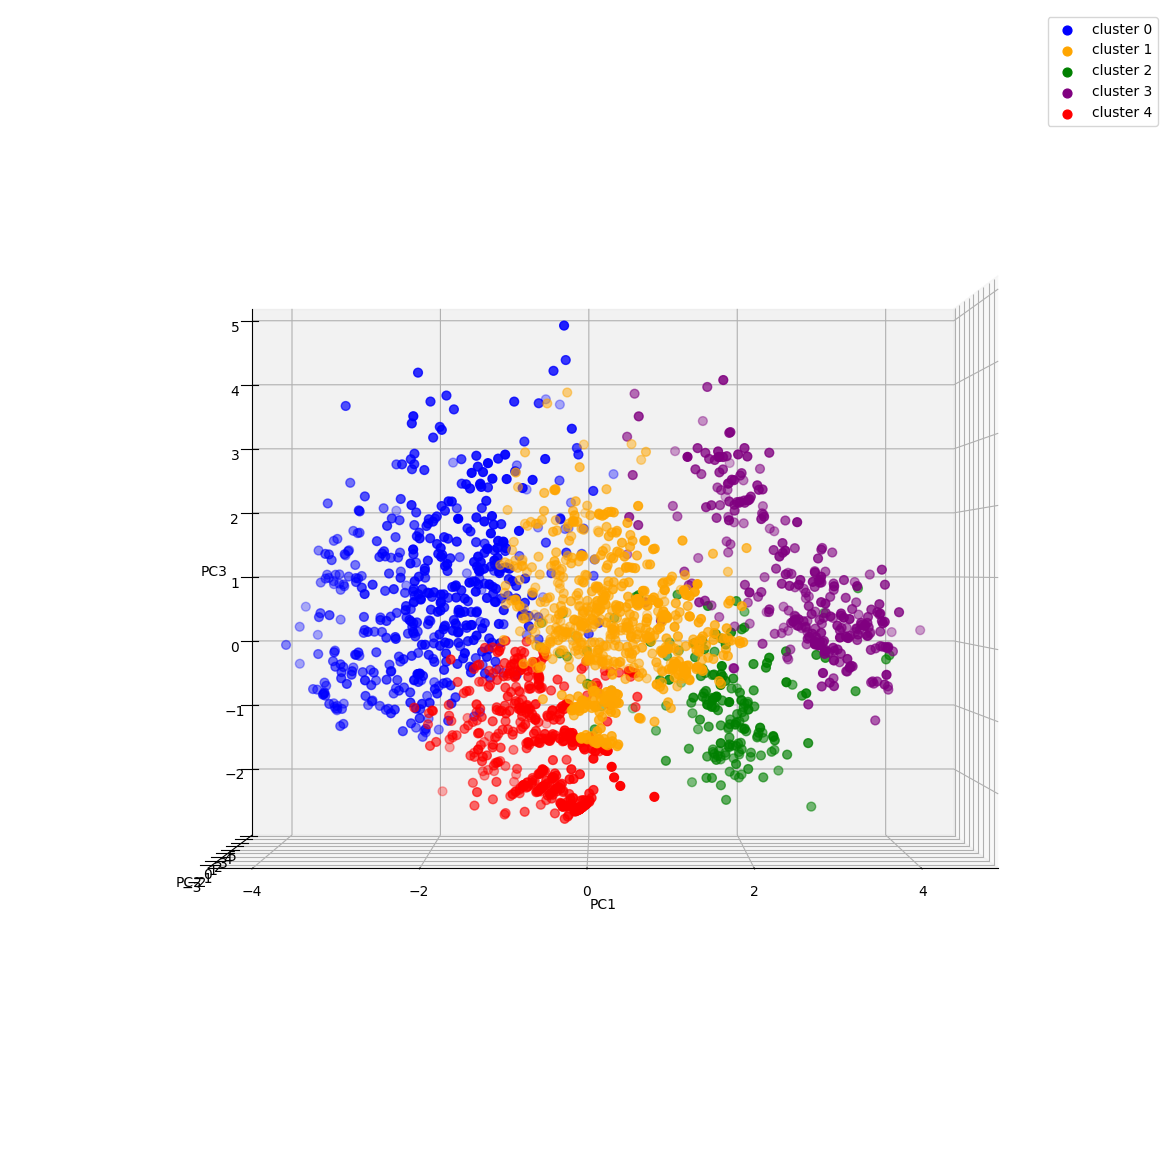

In [56]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_pca[Cluster_2 == 0,0],X1_pca[Cluster_2 == 0,1],X1_pca[Cluster_2 == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(X1_pca[Cluster_2 == 1,0],X1_pca[Cluster_2 == 1,1],X1_pca[Cluster_2 == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(X1_pca[Cluster_2 == 2,0],X1_pca[Cluster_2 == 2,1],X1_pca[Cluster_2 == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(X1_pca[Cluster_2 == 3,0],X1_pca[Cluster_2 == 3,1],X1_pca[Cluster_2 == 3,2], s = 40 , color = 'purple', label = "cluster 3")
ax.scatter(X1_pca[Cluster_2 == 4,0],X1_pca[Cluster_2 == 4,1],X1_pca[Cluster_2 == 4,2], s = 40 , color = 'red', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
ax.view_init(elev=0, azim=-90)
plt.show()